In [101]:
%reload_ext autoreload
%autoreload 2

In [102]:
import sys
sys.path.append('..')
import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns
import numdifftools as nd
from numpy.random import random as rand
from networkqit import graph_laplacian as GL
from scipy.linalg import eigvalsh
from scipy.special import logsumexp
import matplotlib.pyplot as plt
#sns.set(font_scale=1.75)
plt.style.use('default')
# Set the Helvetica font as the default!
import matplotlib as mpl
mpl.rcParams.update({
    'font.family':'sans-serif',
    'font.sans-serif':['Helvetica'],
    'svg.fonttype':'none'
    })
mpl.rc('text', usetex=False)

In [103]:
def ER(n,p):
    T=np.triu(rand([n,n]),1)
    T=T+T.T
    A=(T<p).astype(float)
    np.fill_diagonal(A,0)
    return A

def LER(n,p):
    return GL(ER(n,p))

In [113]:
def quenched_average(n,p,beta,reps):
    
    elogz=0
    for i in range(0,reps):
        elogz += logsumexp(-beta*eigvalsh(LER(n,p)))
    return elogz/reps

def annealed_average(n,p,beta,reps):
    ez=0
    for i in range(0,reps):
        ez += np.exp(-beta*eigvalsh(LER(n,p))).sum()
    return np.log(ez / reps)

def annealed_average_laplacian(n,p,beta):
    return np.log(np.exp(-beta*eigvalsh(GL((1-np.eye(n))*p))).sum())


beta=2
N=64
reps=128
allp = np.linspace(0,1,200)
np.random.seed(0)
elogz = np.array([quenched_average(N,p,beta,reps) for p in allp])
np.random.seed(0)
logez = np.array([annealed_average(N,p,beta,reps) for p in allp])
np.random.seed(0)
logzl = np.array([annealed_average_laplacian(N,p,beta) for p in allp])

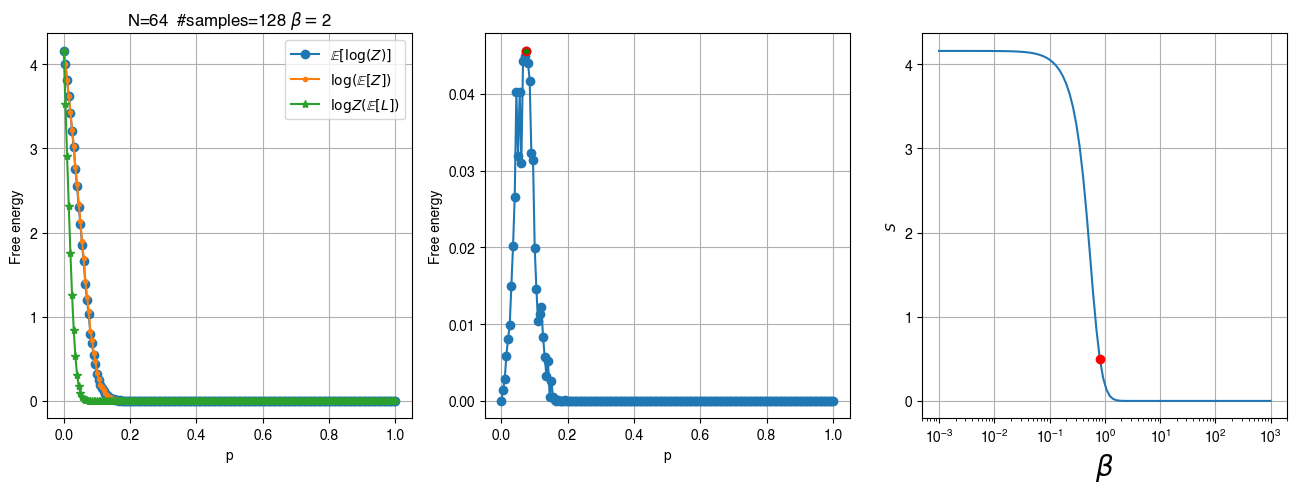

In [114]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(16,5))
ax[0].plot(allp,elogz,'o-')
ax[0].plot(allp,logez,'.-')
ax[0].plot(allp,logzl,'*-')
ax[0].set_xlabel('p')
ax[0].set_ylabel('Free energy')
ax[0].grid()
ax[0].legend(['$\\mathbb{E}[\\log(Z)]$','$\\log (\mathbb{E}[Z])$','$\log Z(\\mathbb{E}[L])$'])
ax[0].set_title('N='+str(N)+'  #samples='+str(reps)+' $\\beta=$'+str(beta))


ax[1].plot(allp,logez-elogz,'o-')
ax[1].set_xlabel('p')
ax[1].set_ylabel('Free energy')
ax[1].grid()
ax[1].plot(allp[np.argmax(logez-elogz)],np.max(logez-elogz),'or')
ax[1].plot( nq.ErdosRenyi(N=N).sample_adjacency(theta=[allp[np.argmax(logez-elogz)]],batch_size=32).mean(0).sum(0).mean()/(N-1),np.max(logez-elogz),'.g')

L=LER(N,0.2)
c = 0.5

S = nq.entropy(L=L,beta_range=np.logspace(-3,3,100))
ax[2].semilogx(np.logspace(-3,3,100),S)
ax[2].semilogx(nq.find_beta_logc(L,np.exp(c)),nq.entropy(L=L,beta_range=[nq.find_beta_logc(L,np.exp(c))]),'ro')

ax[2].set_xlabel('$\\beta$',fontsize=20)
ax[2].grid()
ax[2].set_ylabel('$S$')
plt.savefig('quenched_vs_annealed_er.png',bbox_inches='tight',dpi=300)

In [89]:
nq.graph_laplacian(nq.ErdosRenyi(N=N).sample_adjacency(theta=[allp[np.argmax(logez-elogz)]],batch_size=32).mean(0))

array([[ 5.4375 , -0.03125, -0.0625 , ..., -0.09375, -0.0625 , -0.0625 ],
       [-0.03125,  5.625  , -0.125  , ..., -0.09375, -0.0625 , -0.09375],
       [-0.0625 , -0.125  ,  4.5    , ...,  0.     , -0.03125, -0.09375],
       ...,
       [-0.09375, -0.09375,  0.     , ...,  4.5    , -0.09375, -0.03125],
       [-0.0625 , -0.0625 , -0.03125, ..., -0.09375,  4.65625, -0.03125],
       [-0.0625 , -0.09375, -0.09375, ..., -0.03125, -0.03125,  4.5    ]])

In [77]:
allp[np.argmax(logez-elogz)]*N

8.274747474747475

In [82]:
np.diagonal(LER(N,allp[np.argmax(logez-elogz)])).mean()

8.21875

In [ ]:
L=LER(N,0.2)
S=nq.entropy(L=L,beta_range=np.logspace(-3,3,100))
plt.semilogx(np.logspace(-3,3,100),S)
c=0.2
plt.semilogx(nq.find_beta_logc(L,np.exp(c)),nq.entropy(L=L,beta_range=[nq.find_beta_logc(L,np.exp(c))]),'ro')
nq.find_beta_logc(L,np.exp(c))

In [ ]:
plt.figure(figsize=(18,8))

beta=0.01
N=200
reps=1

elogz = [quenched_average(N,p,beta,reps) for p in np.linspace(0,1,100)]
logez = [annealed_average(N,p,beta,reps) for p in np.linspace(0,1,100)]
logzl = [annealed_average_laplacian(N,p,beta) for p in np.linspace(0,1,100)]
plt.plot(np.linspace(0,1,100),elogz)
plt.plot(np.linspace(0,1,100),logez)
plt.plot(np.linspace(0,1,100),logzl)
plt.xlabel('p')
plt.legend(['$\\mathbb{E}[\\log(Z)]$','$\\log (\mathbb{E}[Z])$','$\log Z(\\mathbb{E}[L])$'])
plt.title('N='+str(N)+'  #samples='+str(reps)+' $\\beta=$'+str(beta))

In [ ]:
np.max(elogz),np.max(logez),np.max(logzl)

In [ ]:
beta=0.1
N=4
reps=100

dquenched = nd.Derivative(lambda x : quenched_average(N,x,beta,reps))
dannealed = nd.Derivative(lambda x : annealed_average(N,x,beta,reps))
daveragelapl = nd.Derivative(lambda x : annealed_average_laplacian(N,x,beta))

dp_quenched = [dquenched(p) for p in np.linspace(0,1,100)]
dp_annealed = [dannealed(p) for p in np.linspace(0,1,100)]
dp_averaged = [daveragelapl(p) for p in np.linspace(0,1,100)]
plt.plot(np.linspace(0,1,100),dp_quenched)
plt.plot(np.linspace(0,1,100),dp_annealed)
plt.plot(np.linspace(0,1,100),dp_averaged)

In [ ]:
N=100
A=ER(N,0.5)
print(nx.density(nx.from_numpy_array(A)))
solver = nq.StochasticGradientDescent(A=A,x0=np.array([0.7,]),beta_range=np.logspace(2,-3,50))
model = nq.ErdosRenyi(N=N)
solver.setup(expected_adj_fun=model, adj_sampling_fun=lambda x: ER(N,x), expected_laplacian_grad=model.expected_laplacian_grad,step_callback=lambda beta,p : print('\r',beta,p,end=''))
sol = solver.run(clip_gradients=None, eta=0.01, num_samples=1,tol=0.5*1E-5)

In [ ]:
N=100
A=ER(N,0.3)
print(nx.density(nx.from_numpy_array(A)))
solver = nq.Adam(A=A,x0=np.array([0.8,]),beta_range=np.logspace(1,-2,20))
model = nq.ErdosRenyi(N=N)
solver.setup(expected_adj_fun=model, adj_sampling_fun=lambda x: ER(N,x), expected_laplacian_grad=model.expected_laplacian_grad,step_callback=lambda beta,p : print('\r',beta,p,end=''))
sol = solver.run(clip_gradients=None,alpha=0.001,num_samples=15,tol=1E-4)

In [ ]:
import pandas as pd
pd.DataFrame(sol).plot(y=['c_er'],x='T',logx=True)
plt.semilogx(1/np.logspace(-2,-3,20),[nx.density(nx.from_numpy_array(A))]*20)